In [76]:
import os
import pandas as pd
import numpy as np
import keras
from keras import layers
import tensorflow as tf
from tensorflow import data as tf_data
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

In [77]:
os.getcwd()

'/home/kevin'

In [78]:
os.chdir('/home/kevin')

In [79]:
dataset_directory = "trafficsigns_dataset"

#Gets class names by listing directories
class_names = sorted(os.listdir(dataset_directory))  # Ensure it's sorted to match the order used by TensorFlow
print("Class names:", class_names)

#prints class name and corresponding index
print("Class names and their corresponding indices:")
for index, name in enumerate(class_names):
    print(f"Class {index}: {name}")

Class names: ['diamond', 'hex', 'round', 'square', 'triangle']
Class names and their corresponding indices:
Class 0: diamond
Class 1: hex
Class 2: round
Class 3: square
Class 4: triangle


In [80]:
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    #20 validation split
    validation_split=0.2
)


In [81]:
# Directory where your images are stored
directory = 'trafficsigns_dataset/'

# Training generator
train_generator = datagen.flow_from_directory(
    directory,
    target_size=(28, 28),
    batch_size=32,
    color_mode='grayscale',
    class_mode='categorical',
    subset='training'
)

# Validation generator
validation_generator = datagen.flow_from_directory(
    directory,
    target_size=(28, 28),
    batch_size=32,
    color_mode='grayscale',
    class_mode='categorical',
    subset='validation'
)

Found 2946 images belonging to 5 classes.
Found 735 images belonging to 5 classes.


In [82]:
import scipy
from scipy.ndimage import gaussian_filter, binary_dilation
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense


In [83]:
#confirming shape of images
batch_size = 32
train_dataset = train_generator[0]

# Print the shapes of the images and labels
print("Images shape:", train_dataset[0].shape)
print("Labels shape:", train_dataset[1].shape)

Images shape: (32, 28, 28, 1)
Labels shape: (32, 5)


In [84]:
num_classes = 5

model = Sequential([
    Conv2D(32, (5, 5), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D(2, 2),
    Conv2D(64, (5, 5), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(num_classes, activation='softmax') 
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=15,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)

Epoch 1/15


/home/kevin/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


92/92 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step - accuracy: 0.4759 - loss: 1.2774 - val_accuracy: 0.5057 - val_loss: 1.2255
Epoch 2/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step - accuracy: 0.5938 - loss: 0.9955 - val_accuracy: 0.5484 - val_loss: 1.2501
Epoch 3/15


2024-05-10 00:38:22.003262: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-05-10 00:38:22.050889: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.5880 - loss: 1.0711 - val_accuracy: 0.6193 - val_loss: 1.1483
Epoch 4/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step - accuracy: 0.5312 - loss: 1.0794 - val_accuracy: 0.6129 - val_loss: 1.0055
Epoch 5/15


2024-05-10 00:38:26.690564: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-10 00:38:26.711195: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - accuracy: 0.6360 - loss: 0.9376 - val_accuracy: 0.6449 - val_loss: 1.0306
Epoch 6/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 672us/step - accuracy: 0.7188 - loss: 0.6461 - val_accuracy: 0.5161 - val_loss: 1.2225
Epoch 7/15


2024-05-10 00:38:31.878770: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-10 00:38:31.912852: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.7008 - loss: 0.7745 - val_accuracy: 0.7088 - val_loss: 0.7880
Epoch 8/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 654us/step - accuracy: 0.8125 - loss: 0.6034 - val_accuracy: 0.7419 - val_loss: 0.8640
Epoch 9/15


2024-05-10 00:38:36.756969: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-10 00:38:36.793208: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - accuracy: 0.7293 - loss: 0.7132 - val_accuracy: 0.7145 - val_loss: 0.8276
Epoch 10/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step - accuracy: 0.7812 - loss: 0.5334 - val_accuracy: 0.7419 - val_loss: 0.8038
Epoch 11/15


2024-05-10 00:38:42.025721: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-10 00:38:42.062165: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


92/92 ━━━━━━━━━━━━━━━━━━━━ 11s 60ms/step - accuracy: 0.7756 - loss: 0.6179 - val_accuracy: 0.7358 - val_loss: 0.7698
Epoch 12/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 514us/step - accuracy: 0.8750 - loss: 0.4825 - val_accuracy: 0.8065 - val_loss: 0.4267
Epoch 13/15


2024-05-10 00:38:52.804213: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-10 00:38:52.832411: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


92/92 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - accuracy: 0.8164 - loss: 0.5050 - val_accuracy: 0.7898 - val_loss: 0.5620
Epoch 14/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 672us/step - accuracy: 0.7500 - loss: 0.6844 - val_accuracy: 0.7419 - val_loss: 0.5959
Epoch 15/15


2024-05-10 00:38:58.404675: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-10 00:38:58.440858: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


92/92 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - accuracy: 0.8378 - loss: 0.4541 - val_accuracy: 0.7670 - val_loss: 0.6863


In [85]:
# epochs = 15
# callbacks = [
#     keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
# ]
# history = model.fit(
#     train_generator,
#     epochs=epochs,
#     callbacks=callbacks,
#     validation_data=validation_generator,
# )

### plot Validation Loss and Training Loss

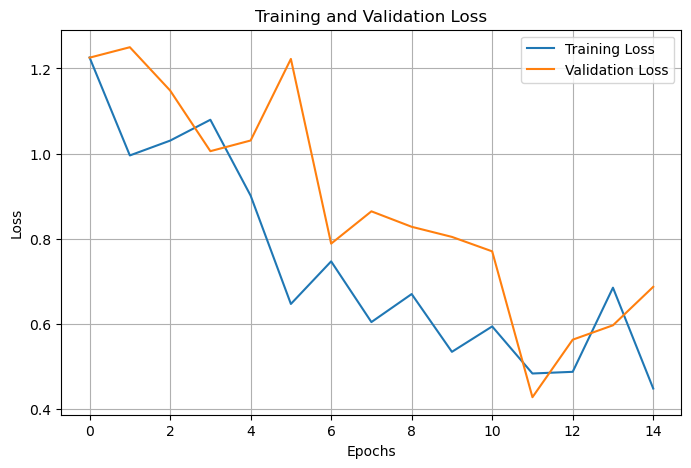

In [86]:
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

### Plot Validation Accuracy and Training Accuracy

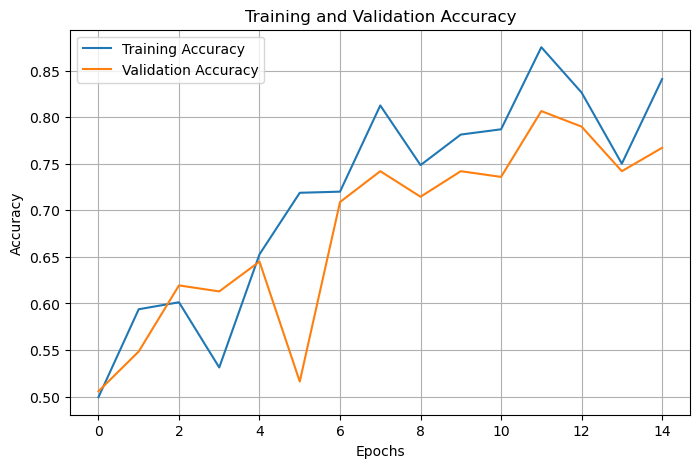

In [87]:
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')  # Change 'loss' to 'accuracy'
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')  # Change 'val_loss' to 'val_accuracy'
plt.title('Training and Validation Accuracy')  # Change title to Accuracy
plt.xlabel('Epochs')
plt.ylabel('Accuracy')  # Change Y-axis label to Accuracy
plt.legend()
plt.grid(True)
plt.show()

### Type classification model

In [88]:
# Do not run unless using google colab
!unzip trafficsigns_dataset_withtype.zip
%ls

unzip:  cannot find or open trafficsigns_dataset_withtype.zip, trafficsigns_dataset_withtype.zip.zip or trafficsigns_dataset_withtype.zip.ZIP.
 A1.ipynb
 AA/
'Act 1_ Basic Text Preprocessing with NLTK Part I.ipynb'
'Act 1_Parsing CSV_TSV Files.ipynb'
'Act 2 _ Bikeshare Trip Data Integration.ipynb'
'Act 2_ Basic Text Preprocessing with NLTK Part II.ipynb'
'Act 2_Parsing JSON Files.ipynb'
'Act 3_ Generating Feature Vectors.ipynb'
'Act 3_Parsing XML files.ipynb'
'Act 4_Document Classification.ipynb'
'Act 5_Fun with word embeddings.ipynb'
'Act 6_ Document classification with embeddings.ipynb'
'Assignment 2-checkpoint.ipynb'
 BostonHousingPrice/
 BostonHousingPrice.zip
 BostonHousingPrice.zip:Zone.Identifier
 CIFAR10_Lab9-1/
 CIFAR10_Lab9-1.zip:Zone.Identifier
 CIFAR10_Lab9-1.zip:shield
 CIFAR_10_BATCH1/
 CIFAR_Data.csv
'Cardiotocography_Data_Set (2).csv:Zone.Identifier'
'Cardiotocography_Data_Set (2).csv:shield'
 Cardiotocography_Data_Set.csv
'Cardiotocography_Data_Set_subset (2).csv:Zone.

In [89]:
import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE

import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

import pandas as pd
import zipfile
with zipfile.ZipFile('./types.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

sign_type_class_names = ['rightofway','stop','bicycle','limitedtraffic','noentry','noparking','roundabout','speed','trafficdirective','traveldirection','continue',
                         'crossing','laneend','parking','giveway','warning']

import glob
image_list = []
for filepath in glob.glob('./types/*/*.png', recursive=True):
    filename = filepath.split('/')[-1]
    sign_type = filepath.split('/')[-2]
    image_list.append((filepath, sign_type))

data = pd.DataFrame(data=image_list, columns=['image_path', 'sign_type'])

from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=42)

In [90]:
train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./',
        x_col="image_path",
        y_col="sign_type",
        target_size=(28, 28),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./',
        x_col="image_path",
        y_col="sign_type",
        target_size=(28, 28),
        batch_size=batch_size,
        class_mode='categorical')

Found 2219 validated image filenames belonging to 16 classes.
Found 740 validated image filenames belonging to 16 classes.


In [91]:
reg_lambda = 0.001
OUTPUT_CLASSES = 16

model_leNet = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(28, 28, 3)),
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None)),


    tf.keras.layers.Conv2D(32, (3, 3), kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),

    tf.keras.layers.Conv2D(32, (3, 3), kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Activation('relu'),

    tf.keras.layers.Conv2D(64, (3, 3)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(OUTPUT_CLASSES, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda))
])

In [92]:
sgd = tf.keras.optimizers.SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model_leNet.compile(optimizer=sgd,
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['categorical_accuracy'])

history = model_leNet.fit(train_generator,
                                    validation_data = validation_generator,
                                    epochs=100, verbose=0)

/home/kevin/.local/lib/python3.10/site-packages/keras/src/optimizers/base_optimizer.py:32: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(
/home/kevin/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


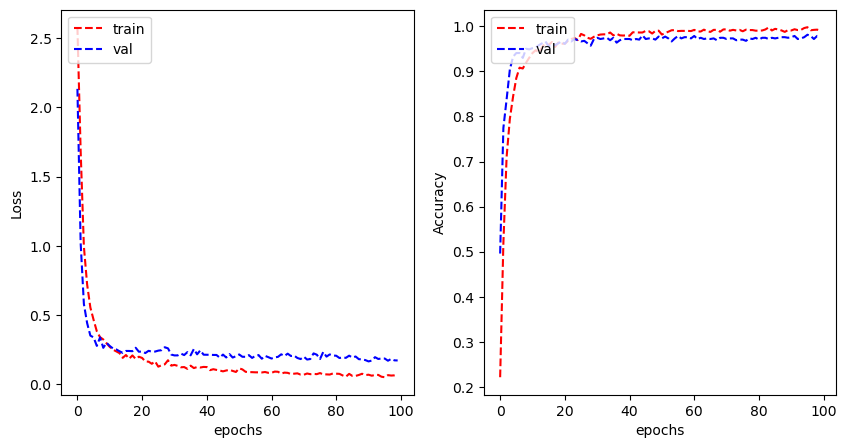

In [93]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], 'r--')
plt.plot(history.history['val_loss'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(history.history['categorical_accuracy'], 'r--')
plt.plot(history.history['val_categorical_accuracy'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.show()

### data Augmentation

In [94]:
train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last',
                                  rotation_range=15, width_shift_range=0.2,
                                  height_shift_range=0.2)
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./',
        x_col="image_path",
        y_col="sign_type",
        target_size=(28, 28),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./',
        x_col="image_path",
        y_col="sign_type",
        target_size=(28, 28),
        batch_size=batch_size,
        class_mode='categorical')

Found 2219 validated image filenames belonging to 16 classes.
Found 740 validated image filenames belonging to 16 classes.


In [95]:
model_leNet_aug = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(28, 28, 3)),
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None)),


    tf.keras.layers.Conv2D(32, (3, 3), kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),

    tf.keras.layers.Conv2D(32, (3, 3), kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Activation('relu'),

    tf.keras.layers.Conv2D(64, (3, 3)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(OUTPUT_CLASSES, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda))
])

model_leNet_aug .compile(optimizer=sgd,
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['categorical_accuracy'])

history = model_leNet_aug .fit(train_generator,
                                    validation_data = validation_generator,
                                    epochs=150, verbose=0)

ValueError: Unknown variable: <KerasVariable shape=(3, 3, 1, 32), dtype=float32, path=sequential_10/conv2d_22/kernel>. This optimizer can only be called for the variables it was originally built with. When working with a new set of variables, you should recreate a new optimizer instance.

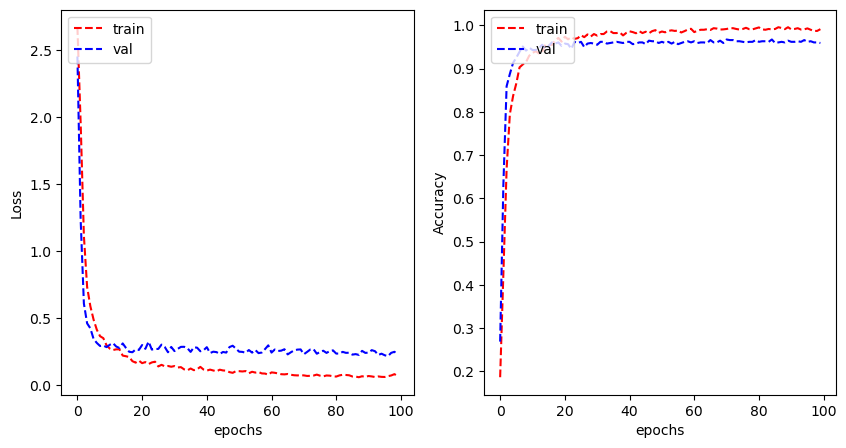

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], 'r--')
plt.plot(history.history['val_loss'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(history.history['categorical_accuracy'], 'r--')
plt.plot(history.history['val_categorical_accuracy'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.show()

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

test_generator = test_datagen.flow_from_dataframe(
    dataframe = test_data,
    directory = './',
    x_col = 'image_path',
    y_col = 'sign_type',
    target_size = (28, 28),
    batch_size = batch_size,
    class_mode = 'categorical'
)

Found 740 validated image filenames belonging to 16 classes.


In [ ]:
model_leNet_aug.evaluate(test_generator)

11/24 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - categorical_accuracy: 0.0918 - loss: 2.8285

/home/kevin/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - categorical_accuracy: 0.0957 - loss: 2.8270


[2.826213836669922, 0.09054054319858551]

### Independent Evaluation

In [ ]:
ind_directory = "trafficsigns_dataset"

In [ ]:
datagen2 = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # Setting 20% of the data for validation
)

In [105]:
import os
from PIL import Image

def resize_and_convert_images(directory, output_directory, size=(28, 28)):
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)
    
    # goes through directory and sub directories
    for root, dirs, files in os.walk(directory):
        for filename in files:
            if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                
                file_path = os.path.join(root, filename)
                
                with Image.open(file_path) as img:
                    # Resize the image
                    img = img.resize(size)
                    # Convert the image to greyscale
                    img = img.convert('L')
                    
                    relative_path = os.path.relpath(root, directory)
                    output_path = os.path.join(output_directory, relative_path)
                    if not os.path.exists(output_path):
                        os.makedirs(output_path)
                    
                    output_file_path = os.path.join(output_path, filename)
                    
                    img.save(output_file_path)
                    print(f'Processed {filename}')

input_directory = 'independant_evaluation_dataset'
output_directory = 'evaluation_images'
resize_and_convert_images(input_directory, output_directory)

Processed noparking_1.png
Processed bicycle_1.png
Processed noentry_2.png
Processed noentry_4.png
Processed noentry_3.png
Processed noentry_1.png
Processed limitedtraffic_1.png
Processed limitedtraffic_2.png
Processed traveldirective_2.png
Processed traveldirective_3.png
Processed traveldirective_1.png
Processed traveldirective_4.png
Processed traveldirection_3.png
Processed traveldirection_1.png
Processed traveldirection_2.png
Processed traveldirection_5.png
Processed traveldirection_4.png
Processed speed_2.png
Processed speed_3.png
Processed speed_1.png
Processed speed_4.png
Processed giveway_1.png
Processed warning_3.png
Processed warning_2.png
Processed warning_1.png
Processed warning_5.png
Processed warning_4.png
Processed parking_1.png
Processed parking_2.png
Processed continue_1.png
Processed crossing_1.png
Processed stop_1.png
Processed rightofway_1.png
